In [1]:
try:
    output_filepath
except:
    output_filepath = 's3://workspaces-clarity-mgmt-pro/jaime.oliver/misc/social_capital/data/processed/'

In [2]:
import os
from pathlib import Path

import pandas as pd
import numpy as np

import patsy
import statsmodels.api as sm
from linearmodels import PanelOLS
from linearmodels import RandomEffects
from linearmodels.panel import BetweenOLS, PooledOLS, compare

from linearmodels import IV2SLS

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})


In [3]:
data_path = os.path.join(output_filepath, 'panel_data.parquet')
df_model = pd.read_parquet(data_path)

df_model = df_model[df_model.year.between(2001, 2016)]

df_model['human_authorities_cero'] = np.isclose(df_model.human_authorities, 0)
df_model['receiving_cuntries'] = df_model.groupby('country').human_authorities_cero.transform(lambda x: sum(x)<len(x))
#df_model = df_model[df_model.receiving_cuntries]

centralities = ['hubs', 'authorities','pagerank', 'gfi', 'bridging', 'favor']
networks = ['financial', 'goods', 'human']
networks = ['financial', 'goods', 'estimated_human']

In [4]:
df_model[df_model.receiving_cuntries].country.unique()

array(['AUS', 'AUT', 'BEL', 'CAN', 'CHE', 'CHL', 'CZE', 'DEU', 'DNK',
       'ESP', 'EST', 'FIN', 'FRA', 'GBR', 'GRC', 'HUN', 'IRL', 'ISL',
       'ISR', 'ITA', 'JPN', 'KOR', 'LUX', 'LVA', 'MEX', 'NLD', 'NOR',
       'NZL', 'POL', 'PRT', 'SVK', 'SVN', 'SWE', 'TUR', 'USA'],
      dtype=object)

In [5]:
[f'{n}_{c}' for c in centralities for n in networks]

['financial_hubs',
 'goods_hubs',
 'estimated_human_hubs',
 'financial_authorities',
 'goods_authorities',
 'estimated_human_authorities',
 'financial_pagerank',
 'goods_pagerank',
 'estimated_human_pagerank',
 'financial_gfi',
 'goods_gfi',
 'estimated_human_gfi',
 'financial_bridging',
 'goods_bridging',
 'estimated_human_bridging',
 'financial_favor',
 'goods_favor',
 'estimated_human_favor']

In [6]:
corr_cols = ['log_output', 'log_gdp', 'gini', 'log_GFCF', 'log_wkn_population'] + [f'{n}_{c}' for c in centralities for n in networks]

for c in [f'{n}_{c}' for c in centralities for n in networks]:
    df_model[c] = df_model[c].map(lambda x: np.log1p(x*1.e8))

df_model[['country', 'year'] + corr_cols].describe(include='all').T

/home/ubuntu/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log1p
  after removing the cwd from sys.path.


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
country,2731,171,BRN,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,2731,NaN,NaN,NaN,2008.49,4.60842,2001,2004,2008,2012,2016
log_output,2731,NaN,NaN,NaN,17.9249,2.23266,10.8685,16.3944,17.6934,19.6174,24.1941
log_gdp,2731,NaN,NaN,NaN,17.1583,2.32031,7.3328,15.6644,16.9492,18.884,23.5039
gini,359,NaN,NaN,NaN,0.319203,0.0594887,0.234,0.2695,0.315,0.348,0.62
log_GFCF,2511,NaN,NaN,NaN,22.8906,2.58599,0,21.468,22.7439,24.5476,29.1997
log_wkn_population,2731,NaN,NaN,NaN,15.1326,1.71139,10.7088,14.1218,15.1731,16.2155,20.4811
financial_hubs,2731,NaN,NaN,NaN,12.8838,0.71538,10.2929,12.3853,12.8415,13.3716,15.8608
goods_hubs,2731,NaN,NaN,NaN,12.1586,1.19763,8.97596,11.4028,12.1206,12.9755,17.0341
estimated_human_hubs,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


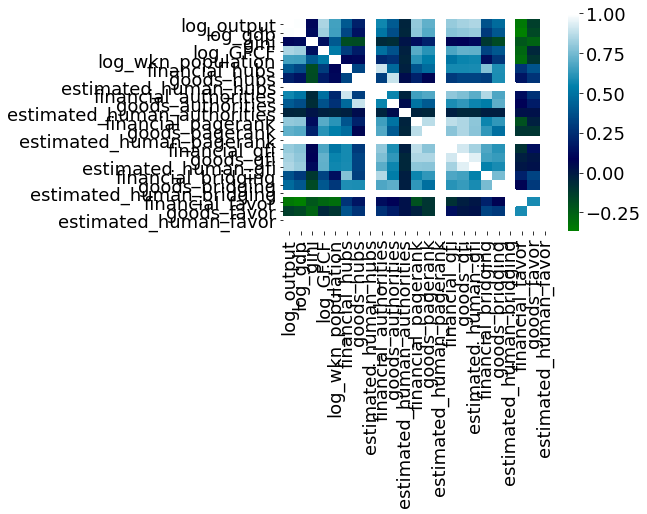

In [7]:
plt.rcParams.update({'font.size': 18})

corr = df_model[corr_cols].corr()

# plot the heatmap
sns.heatmap(corr, cmap="ocean",
        xticklabels=corr.columns,
        yticklabels=corr.columns,)

# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.7 # Add 0.5 to the bottom
t -= 0.7 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!

## Variable selection
Some of the social capital variables we want to include are highly correlated --> need to reduce dimensionality in order to avoid multicolinearity


In [8]:
all_terms_list = [f'{n}_{c}' for c in centralities for n in networks]

In [9]:
from scipy.stats import pearsonr
import statsmodels.api as sm

def corrfunc(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    plt.rcParams.update({'font.size': 15})

    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    rho = '\u03C1'
    ax.annotate(f'{rho} = {r:.2f}', xy=(.5, .1), xycoords=ax.transAxes)

def r2func(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    plt.rcParams.update({'font.size': 15})

    x = sm.add_constant(x)
    model = sm.OLS(y,x)
    results = model.fit()
    r2 = results.rsquared

    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    ax.annotate(f'$R^2$= {r2:.2f}', xy=(.5, .1), xycoords=ax.transAxes)



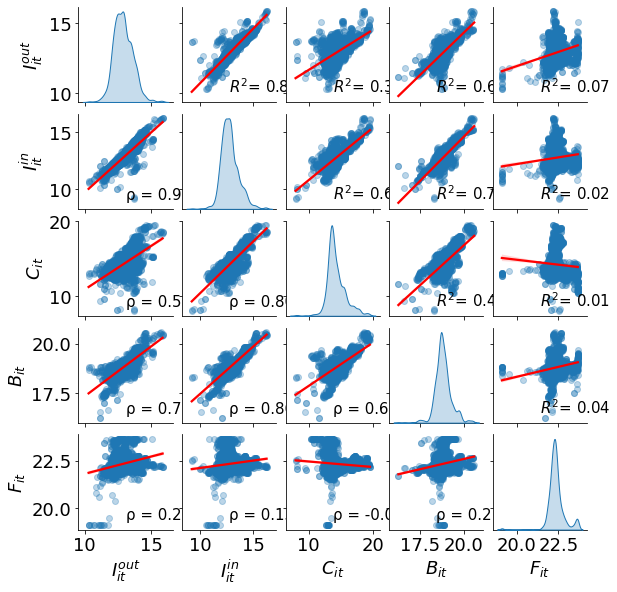

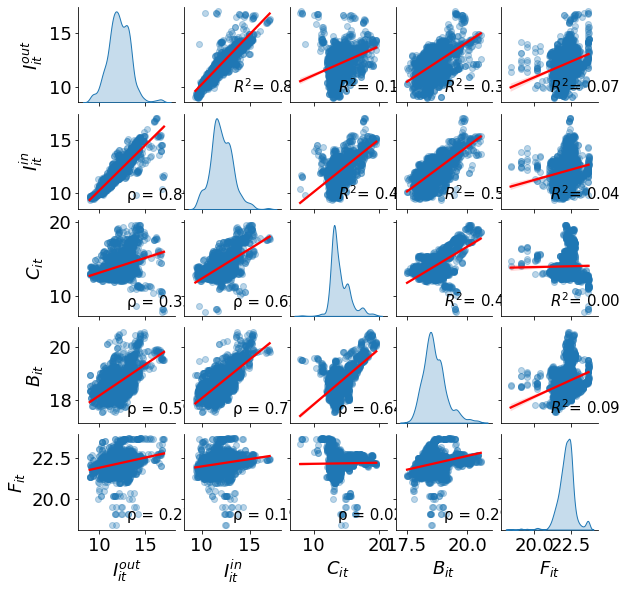

/home/ubuntu/.local/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


ValueError: array must not contain infs or NaNs

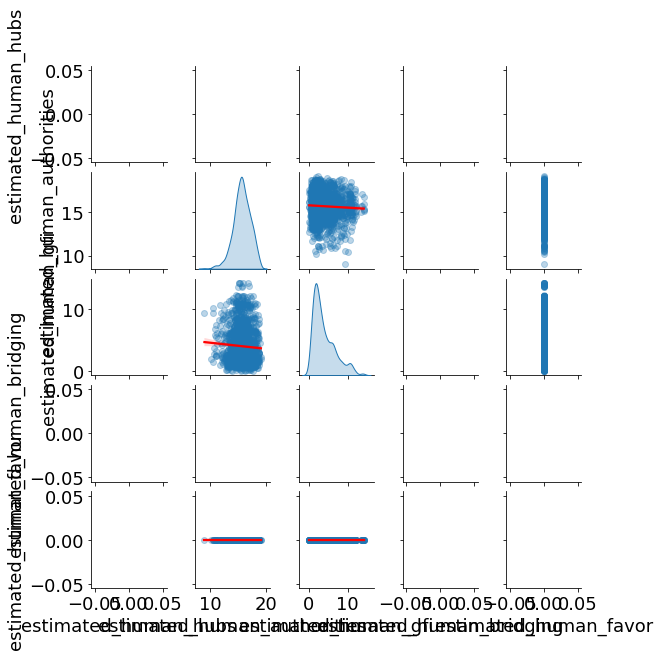

In [11]:
for n in networks:
    corr_cols = [f'{n}_{c}' for c in ['hubs', 'authorities', 'gfi', 'bridging', 'favor']] 

    plt.rcParams.update({'font.size': 18})

    g = sns.pairplot(df_model[corr_cols], kind='reg', diag_kind = 'kde', plot_kws={'scatter_kws': {'alpha': 0.3}, 'line_kws':{'color':'red'}})
    g.fig.set_size_inches(8,8)
    g.map_lower(corrfunc)
    g.map_upper(r2func)

    names = dict(zip(corr_cols, ['$I_{it}^{out}$', '$I_{it}^{in}$', '$C_{it}$', '$B_{it}$', '$F_{it}$'] ))

    plt.rcParams.update({'font.size': 18})
    for i in range(len(corr_cols)):
        for j in range(len(corr_cols)):
            xlabel = g.axes[i][j].get_xlabel()
            ylabel = g.axes[i][j].get_ylabel()
            if xlabel in names.keys():
                g.axes[i][j].set_xlabel(names[xlabel])
            if ylabel in names.keys():
                g.axes[i][j].set_ylabel(names[ylabel])

    save_to = os.path.join(Path(os.getcwd()).parent.resolve(), 'reports', 'figures', f'{n}_social_capital_multicolinearity.png')
    plt.savefig(save_to)    
    plt.show()

## Simultaneous model capital and migration

In [ ]:
all_terms_regression = ' + '.join(all_terms_list)

In [ ]:
f = f'log_gdp ~ {all_terms_regression} + log_GFCF + log_wkn_population + 1'
y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')

model = RandomEffects(y,X)

be_res = BetweenOLS(y,X)
be_res = be_res.fit()

model = PooledOLS(y,X)
pooled_res = model.fit()

model = RandomEffects(y,X)
re_res = model.fit()

compare({'BE':be_res,'RE':re_res,'Pooled':pooled_res})

## Stacked results

In [13]:
def stacked_results(y_label, centralities, estimator = RandomEffects):

    X_terms_list =  [f'{n}_{c}' for c in centralities for n in networks]
    all_terms_regression = ' + '.join(X_terms_list)
    f = f'{y_label} ~ {all_terms_regression} + log_GFCF + log_wkn_population + 1'
    y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')
    model = estimator(y,X)
    results_combined_model = model.fit()

    df_results = pd.DataFrame(results_combined_model.params).reset_index()
    df_results['pvalues'] = results_combined_model.pvalues.values
    df_results['show_value'] = df_results.apply(lambda x: f'{round(x.parameter,4)} ({round(x.pvalues, 5)})', axis=1)
    df_results = df_results[~df_results['index'].isin(['Intercept','log_GFCF','log_wkn_population'])]
    df_results['network'], df_results['capital'] = zip(*df_results['index'].map(lambda x: (x.split('_')[0], x.split('_')[1])))
    print(f'''Results regression analysis: {y_label} ''')
    df_results = df_results.pivot_table(index='network', columns = 'capital', values = 'show_value', aggfunc=np.unique)
    
    return df_results

stacked_results('log_gdp', centralities)

/home/ubuntu/.local/lib/python3.7/site-packages/linearmodels/panel/data.py:98: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


ValueError: zero-size array to reduction operation maximum which has no identity

In [12]:
stacked_results('gini', centralities)

NameError: name 'stacked_results' is not defined

In [ ]:
reduced_centralities = ['hubs', 'authorities', 'favor']
stacked_results('log_gdp', reduced_centralities)

In [ ]:
stacked_results('gini', reduced_centralities)

## MODEL COMPARISON

In [ ]:
all_terms_regression = ' + '.join(all_terms_list)
reduced_terms_list = ['financial_' + c for c in reduced_centralities] + ['goods_' + c for c in reduced_centralities] + ['human_' + c for c in reduced_centralities]
reduced_terms_list = ['financial_hubs', 
                      'financial_authorities', 
                      'goods_hubs', 
                      'goods_authorities', 
                      'human_hubs', 
                      'human_authorities',
                      'human_favor']

reduced_terms_regression = ' + '.join(reduced_terms_list)


In [ ]:
f = f'log_gdp ~ log_GFCF + log_wkn_population + 1'
y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')
base_model = RandomEffects(y,X)
base_model = base_model.fit()

f = f'log_gdp ~ {all_terms_regression} + log_GFCF + log_wkn_population + 1'
y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')
full_model = RandomEffects(y,X)
full_model = full_model.fit()

f = f'log_gdp ~ {reduced_terms_regression} + log_GFCF + log_wkn_population + 1'
y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')
reduced_model = RandomEffects(y,X)
reduced_model = reduced_model.fit()

c = compare({'Base Model':base_model,
             #'Full Model':full_model, 
             'Reduced Model':reduced_model}, precision='pvalues')
#print(c.summary.as_latex())
c.summary

## VIF

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(df_model[reduced_terms_list].values, i) for i in range(len(reduced_terms_list))]

print(vif)

## PCA variables

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

n = 5

pipe = Pipeline([
        ('scale', StandardScaler()),
        ('reduce_dims', PCA(n_components=n))]
        )

all_terms = [[n + '_' + c for c in centralities] for n in ['financial', 'human']]
all_terms = [item for sublist in all_terms for item in sublist]
all_terms = reduced_terms_list.copy()
df_model[[f'pca_{i}' for i in range(n)]] = pipe.fit_transform(df_model[all_terms])

print(pipe['reduce_dims'].explained_variance_ratio_)
print(pipe['reduce_dims'].components_)

In [ ]:
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('reduce_dims', PCA(n_components=n))]
        )
pipe.fit(df_model[all_terms])

plt.plot(np.cumsum(pipe['reduce_dims'].explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [ ]:
f = 'log_gdp ~ log_GFCF + log_wkn_population + 1 + ' + ' + '.join([f'pca_{i}' for i in range(n)])
y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')

model = RandomEffects(y,X)
results = model.fit()
results.summary

In [ ]:
df_radar = pd.DataFrame(pipe['reduce_dims'].components_, columns = all_terms)
df_radar.loc[:,'coefs'] = pd.Series(results.params[[f'pca_{i}' for i in range(n)]].values)
df_radar['pvalues'] = pd.Series(results.pvalues[[f'pca_{i}' for i in range(n)]].values)

labels = all_terms.copy()
stats = pipe['reduce_dims'].components_[0]

angles=np.linspace(0, 2*np.pi, len(all_terms), endpoint=False)

fig=plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, polar=True)

for i in range(n):
    stats = df_radar.loc[i,all_terms]
    c = round(df_radar.loc[i,'coefs'], 3)
    p =  round(df_radar.loc[i,'pvalues'], 3)
    ax.plot(np.concatenate((angles,[angles[0]])), np.concatenate((stats,[stats[0]])), 
            'o-', 
            linewidth=2, 
            label = f'effect: {c} (p: {p})'
)
    ax.fill(angles, stats, alpha=0.25)
plt.legend()
ax.set_thetagrids(angles * 180/np.pi, labels)
ax.grid(True)

## Time series

In [ ]:
lagged_all_terms_list = ['delta_financial_' + c for c in reduced_centralities] + ['delta_human_' + c for c in reduced_centralities]
lagged_all_terms_list = ' + '.join(lagged_all_terms_list)

In [ ]:
model = IV2SLS(df_model.delta_log_output, df_model[['financial_' + c for c in reduced_centralities] + ['human_' + c for c in reduced_centralities] + ['constant']], df_model.lag_log_output, df_model.lag_log2_output)
results = model.fit()
results.summary

In [ ]:
print(results.summary.as_latex())